In [ ]:
!pip install torchvision
!pip install wandb

### Dependencies

In [2]:
import torch
from torch import nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda import amp
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from PIL import Image

# from models import Generator, Discriminator
import gc

from tqdm import tqdm
import os
import random
import sys
import time
import copy
from collections import defaultdict

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Login to Weights & Biases

In [3]:
import wandb

API_KEY = "5156658a1eec69dd17b8fada84a91056f96da322"

wandb.login(key=API_KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: houda-ghallab (houda222). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hghallab/.netrc


True

In [4]:
class CFG:
    seed          = 12
    debug         = False
    model_name    = 'DCGAN|FirstGan'
    loss_function = 'BCELoss'
    train_bs      = 8
    valid_bs      = 8
    img_size      = [512, 512]
    # input_size    = [736, 1280]
    epochs        = 500
    lr            = 2e-4
    n_accumulate  = max(1, 32//train_bs)
    # num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
print(CFG.device)

cpu


In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


### Data Loading


In [17]:
data_dir = "/home/hghallab/dataset/GANs_dataset/OneImageSet"

In [18]:
# Define the transform 
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(CFG.img_size),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [19]:
# torchvision.io.read_image
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.Tensor(img)
    return img

In [20]:
class ganData(torch.utils.data.Dataset):
    def __init__(self, transform=transform, data_dir=data_dir):
        self.data_dir = data_dir
        self.transform = transform
        self.images_path = data_dir
        self.images = os.listdir(self.images_path)
    
    def __len__(self):
        return len(os.listdir(self.images_path))
    
    def __getitem__(self, idx):
        item_name = self.images[idx]
        img = load_img(os.path.join(self.images_path, item_name))
        img = self.transform(img)
        # img = Image.fromarray(img)
        return img

In [21]:
dataset = ganData()

if CFG.debug:
    train_data, valid_data, _ = torch.utils.data.random_split(dataset, [0.1, 0.1, 0.8])
else:
    train_data, valid_data = torch.utils.data.random_split(dataset, [1, 0])


train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False) # num_workers=0 for debugging else 4
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True) # num_workers=0 for debugging else 4


/home/hghallab/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [22]:
def visualize_item(image, gt=None, pred=None):
    image_np = image.cpu().numpy() if image.is_cuda else image.numpy()
    image_np = image_np.squeeze()
    image_np = np.transpose(image_np, (1, 2, 0)).astype("uint8")
    plt.axis('off')
    plt.imshow(image_np)
    plt.show()

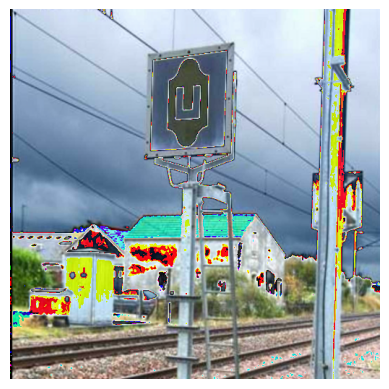

In [23]:
for img in next(iter(train_loader)):
    visualize_item(img)
    break

### Model 

Definition of Generator and Discriminator. 



In [25]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(3)
        self.deconv6 = nn.ConvTranspose2d(3, 3, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(3)
        self.deconv7 = nn.ConvTranspose2d(3, 3, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(3)
        self.deconv8 = nn.ConvTranspose2d(3, 3, 4, 2, 1)


    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        # print("gen", input.shape)
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        # print("gen", x.shape)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        # print("gen", x.shape)
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        # print("gen", x.shape)
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        # print("gen", x.shape)
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        # print("gen", x.shape)
        x = F.relu(self.deconv6_bn(self.deconv6(x)))
        # print("gen", x.shape)
        x = F.relu(self.deconv7_bn(self.deconv7(x)))
        # print("gen", x.shape)
        x = torch.tanh(self.deconv8(x))
        # print("gen", x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d*8)
        self.conv6 = nn.Conv2d(d*8, d*8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d*8)
        self.conv7 = nn.Conv2d(d*8, d*8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d*8)         
        self.conv8 = nn.Conv2d(d*8, 1, 4, 1, 0)

        # self.dense = nn.Linear(d*8*32*32, 2)

    def forward(self, input):
        # print("input shape", input.shape)
        x = F.leaky_relu(self.conv1(input), 0.2)
        # print("after layer one", x.shape)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        # print("after layer two", x.shape)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        # print("after layer three", x.shape)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        # print("after layer four", x.shape)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        # print("after layer 5", x.shape)
        x = F.leaky_relu(self.conv6_bn(self.conv6(x)), 0.2)
        # print("after layer 6", x.shape)
        x = F.leaky_relu(self.conv7_bn(self.conv7(x)), 0.2)
        # print("after layer 7", x.shape)
        x = self.conv8(x)
        # x = torch.sigmoid(x)
        # x = torch.sigmoid(self.dense(self.conv5(x).reshape(-1, 512*59*59)))
        return x

In [26]:
    
generator = Generator()
discriminator = Discriminator()

device = torch.device(CFG.device)
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in 
generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12660814 and discriminator: 61378945


In [27]:
print(generator)
print(discriminator)

Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv5_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv6): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), p

### WandB space

In [28]:
# Generate fixed noise vector to visualize the progression of the generator
noise = torch.randn(CFG.train_bs, 100, 1, 1, device=device)

def visualize_generated_images(generator, latent, epoch):
  """
  Generates and visualizes images from the given generator model.

  Args:
      generator: The generator model to use for image generation.
      num_images: The number of images to generate and visualize.
  """

  # Generate fake images
  fake_images = generator(noise)

  # Normalize and convert to image format (if necessary)
  # fake_images = (fake_images - fake_images.min()) / (fake_images.max() - fake_images.min())  # Normalize
  fake_images = fake_images.detach().cpu() * 255  # Convert to 0-255 range (assuming uint8)
  fake_images = fake_images.permute(0, 2, 3, 1).to(torch.uint8)  # Permute if channels are not last

  plt.figure(figsize=(24, 3))
  for i in range(len(fake_images)):
    plt.subplot(1, 8, i+1)
    plt.imshow(fake_images[i])
    plt.axis('off')
  plt.suptitle(f"Generated Images - Epoch {epoch + 1}", fontsize=12)  # Add title
  plt.tight_layout()
  plt.show()

In [13]:
MODEL_WORKSPACE = "/home/hghallab/Dvlp/GANs/DCGAN"
os.chdir(MODEL_WORKSPACE)
runs = sorted(os.listdir(os.path.join(MODEL_WORKSPACE, "runs")))
if len(runs) == 0:
    CURRENT_MODEL_DIR = "runs/" + "run_1"
else:
    CURRENT_MODEL_DIR = "runs/" + f"run_{int(runs[-1].split('_')[-1]) + 1}"
os.mkdir(os.path.join(MODEL_WORKSPACE, CURRENT_MODEL_DIR))

In [48]:
run = wandb.init(project='DCGAN', 
                config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                name=f"{CURRENT_MODEL_DIR}|model-{CFG.model_name}",
                )

NameError: name 'wandb' is not defined

### Training

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [30]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(1024, 1024, 

In [31]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

criterion = torch.nn.BCEWithLogitsLoss()


In [33]:
# # set to training mode
# generator.train()
# discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
img_list = []

print('Training ...')

# wandb.watch(generator, log_freq=100)
# wandb.watch(discriminator, log_freq=100)

start = time.time()

best_model_gen = copy.deepcopy(generator.state_dict())
best_model_disc = copy.deepcopy(discriminator.state_dict())
best_epoch     = -1
best_disc_loss = np.inf
best_gen_loss = np.inf
history = defaultdict(list)

for epoch in range(CFG.epochs):
    
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in train_loader:
        
        ##################################
        ###### Discriminator ######
        discriminator.zero_grad()
        
        ## real batch
        # Forward pass real batch through discriminator
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        
        real_pred = discriminator(image_batch).squeeze()
        disc_real_loss = criterion(real_pred, label_real)
        
        # Calculate gradient for D in backward pass
        disc_real_loss.backward()
        D_x = real_pred.mean().item()

        ## Fake batch
        # Forward pass fake batch through discriminator
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)
        
        fake_image_batch = generator(latent)
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_fake_loss = criterion(fake_pred, label_fake)

        # Calculate gradient for D in backward pass
        disc_fake_loss.backward()
        D_G_z1 = fake_image_batch.mean().item()

        disc_loss = disc_fake_loss + disc_real_loss
        
        # Update discriminator
        disc_optimizer.step()
        
        ##################################
        ###### Generator ######
        generator.zero_grad()

        # Forward pass of fake batch through D
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = criterion(fake_pred, label_real)
        
        # Backward pass
        gen_loss.backward()
        D_G_z2 = fake_pred.mean().item()

        # Update generator
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
    
    fake_image_batch_ = fake_image_batch.detach().cpu() * 255 
    fake_image_batch_ = fake_image_batch_.permute(0, 2, 3, 1).to(torch.uint8)  # Permute if channels are not last

    plt.figure(figsize=(24, 3))
    for i in range(len(fake_image_batch_)):
        plt.subplot(1, 8, i+1)
        plt.imshow(fake_image_batch_[i])
        plt.axis('off')
    plt.suptitle(f"Fake images batch - Epoch {epoch + 1}", fontsize=12)  
    plt.tight_layout()
    
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    
 
    visualize_generated_images(generator, latent, epoch)
    
    # # deep copy the model
    # if disc_loss_avg[-1] >= best_disc_loss:
    #     print(f"{c_}Valid Score Improved ({best_disc_loss:0.4f} ---> {disc_loss_avg[-1]:0.4f})")
    #     best_disc_loss   = disc_loss_avg[-1]
    #     best_epoch   = epoch
    #     run.summary["Best Disriminator Loss"]    = best_disc_loss
    #     run.summary["Corresponding Generator Loss"] = gen_loss_avg[-1] 
    #     run.summary["Best Epoch"]   = best_epoch
    #     best_model_gen = copy.deepcopy(generator.state_dict())
    #     best_model_disc = copy.deepcopy(discriminator.state_dict())
    #     # PATH = f"best_epoch-{fold:02d}.bin"
    #     PATH = f"{CURRENT_MODEL_DIR}/best_epoch.bin"
    #     torch.save(generator.state_dict(), PATH)
    #     torch.save(discriminator.state_dict(), PATH)        
    #     # Save a model file from the current directory
    #     wandb.save(PATH)
    #     print(f"Model Saved{sr_}")
    
    # # Log the metrics
    # wandb.log({"Discriminator Loss": disc_loss_avg[-1], 
    #            "Generator Loss": gen_loss_avg[-1],})
    
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, CFG.epochs, gen_loss.item(), disc_loss.item()))

    
history['Discriminator Loss'] = disc_loss_avg
history['Generator Loss'] = gen_loss_avg

    
end = time.time()

time_elapsed = end - start
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print("Best Score: {:.4f}".format(best_disc_loss))


Training ...


KeyboardInterrupt: 

In [27]:
import gc
gc.collect()

345